# Using GPUs to accelerate training and inference
In this notebook, we will see the advantage of using GPUs to do training and inference.

**Note:** The results in this notebook are only relevant if you are running on a machine with a GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GPSat.models.sklearn_models import sklearnGPRModel
from GPSat.models.gpflow_models import GPflowGPRModel

2023-08-02 14:07:29.561400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 14:07:30.152340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/so/miniconda3/envs/gpsat/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/so/miniconda3/envs/gpsat/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  

For the experiment, we use the same model as before but sampling more data points.

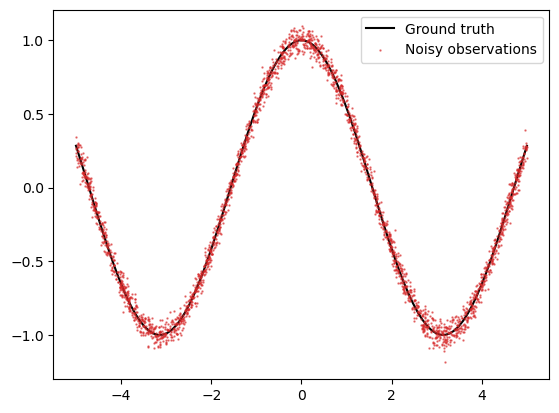

In [2]:
# Set random seed
np.random.seed(0)

# Generate data
N = 2500
L = 5
noise_std = 0.05

X_grid = np.linspace(-L, L, 100)
X = np.random.uniform(-L, L, (N,))
f = lambda x: np.cos(x)
epsilon = noise_std * np.random.randn(N)

y = f(X) + epsilon
f_truth = f(X_grid) # Ground truth

# Plot
plt.plot(X_grid, f_truth, 'k', zorder=1, label='Ground truth')
plt.scatter(X, y, color='C3', alpha=0.6, zorder=2, s=0.5, label='Noisy observations')
plt.legend()

As before, we model this data using ``sklearnGPRModel``. Scikit-learn does not have GPU support so this will do all the training and prediciton on CPU, even if it detects GPUs on the machine.

In [3]:
# ---------------
# Training on CPU
# ---------------

# Initialise sklearn GPR model
sklearn_gpr = sklearnGPRModel(coords=X, obs=y, kernel='RBF', likelihood_variance=noise_std**2, verbose=False)

# Train model
_ = sklearn_gpr.optimise_parameters()

# Predict on test points
pred_dict_sklearn = sklearn_gpr.predict(X_grid[:,None])


found GPU
'__init__': 1.206 seconds


2023-08-02 14:07:34.661093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-02 14:07:34.661674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 42.258 seconds
'predict': 0.012 seconds


Now, let's use ``GPflowGPRModel`` to model the same data, which is based on the python package ``GPflow``, itself a tensorflow based package for modelling with GPs. This automatically does the training and prediction on GPUs, if available.

In [11]:
# ---------------
# Training on GPU
# ---------------

# Initialise GPflow GPR model
gpflow_gpr = GPflowGPRModel(coords=X, obs=y, kernel='RBF', noise_variance=noise_std**2, verbose=False)

# Train model
_ = gpflow_gpr.optimise_parameters(fixed_params=['likelihood_variance'])

# Predict on test points
pred_dict_gpflow = gpflow_gpr.predict(X_grid[:,None])


found GPU
setting lengthscales to: [1.]
'__init__': 0.195 seconds
setting parameter likelihood_variance to be untrainable


2023-08-02 14:11:00.478252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 6618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-08-02 14:11:00.478796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 5973 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:65:00.0, compute capability: 7.5


'optimise_parameters': 5.645 seconds
'predict': 0.176 seconds


**Note:** In ``GPflowGPRModel``, the likelihood variance is initialised with the argument ``noise_variance`` instead of ``likelihood_variance`` as in ``sklearnGPRModel``. Note also that since likelihood variance is a trainable parameter in ``GPflowGPRModel``, we pass an additional argument ``fixed_params = ['likelihood_variance']`` to the ``optimise_parameters()`` method to freeze the assigned likelhood variance value. For more details, see the API references for both models.

We see that training time is much shorter on a GPU than on CPU, which is where most of the computation takes place in the enitre GP workflow. Hence, when we have a large dataset, it is advantageous to use GPUs over CPUs.

We can also check that the results of the two predictions are near identical:

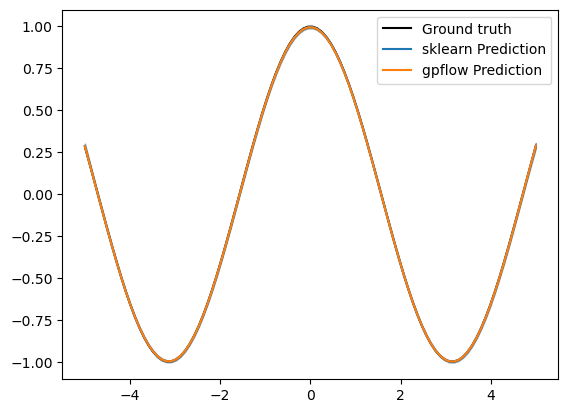

In [12]:
# Extract mean and variance for the sklearn prediction
f_mean_sklearn = pred_dict_sklearn['f*']
f_var_sklearn = pred_dict_sklearn['f*_var']
f_std_sklearn = np.sqrt(f_var_sklearn)

# Extract mean and variance for the gpflow prediction
f_mean_gpflow = pred_dict_gpflow['f*']
f_var_gpflow = pred_dict_gpflow['f*_var']
f_std_gpflow = np.sqrt(f_var_gpflow)

# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_grid, f_mean_sklearn, color='C0', zorder=1, label='sklearn Prediction')
plt.fill_between(X_grid, f_mean_sklearn-1.96*f_std_sklearn, f_mean_sklearn+1.96*f_std_sklearn, color='C0', alpha=0.6)
plt.plot(X_grid, f_mean_gpflow, color='C1', zorder=1, label='gpflow Prediction')
plt.fill_between(X_grid, f_mean_gpflow-1.96*f_std_gpflow, f_mean_gpflow+1.96*f_std_gpflow, color='C1', alpha=0.2)
plt.legend()